In [10]:
import datapane as dp
import pandas as pd
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)
kw_list = 'unclog toilet'


In [2]:
pytrends.build_payload([kw_list], cat=0, timeframe='today 5-y', geo='US', gprop='')


In [3]:
r_o_t = pytrends.interest_over_time().reset_index()

In [4]:
regions = pytrends.interest_by_region(resolution='REGION', inc_geo_code=True)

In [5]:
df = r_o_t.rename(columns={'date':'ds', f'{kw_list}': 'y'})
geo = regions[regions['unclog toilet'] > 0].reset_index()
geo


,geoName,geoCode,unclog toilet
0,Alabama,US-AL,79
1,Arizona,US-AZ,76
2,Arkansas,US-AR,88
3,California,US-CA,72
4,Colorado,US-CO,72
5,Connecticut,US-CT,70
6,Delaware,US-DE,87
7,District of Columbia,US-DC,58
8,Florida,US-FL,73
9,Georgia,US-GA,89


In [6]:
import altair as alt

trends = alt.Chart(df, title=f'Historical trend for {kw_list}').encode(x='ds:T', y='y').mark_line().interactive()
trends

trends_month = alt.Chart(df, title=f'Monthly trend for {kw_list}').encode(x='month(ds):T', y='mean(y)').mark_bar(opacity=0.9).interactive()
all_trends = trends | trends_month


In [7]:
from fbprophet import Prophet

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


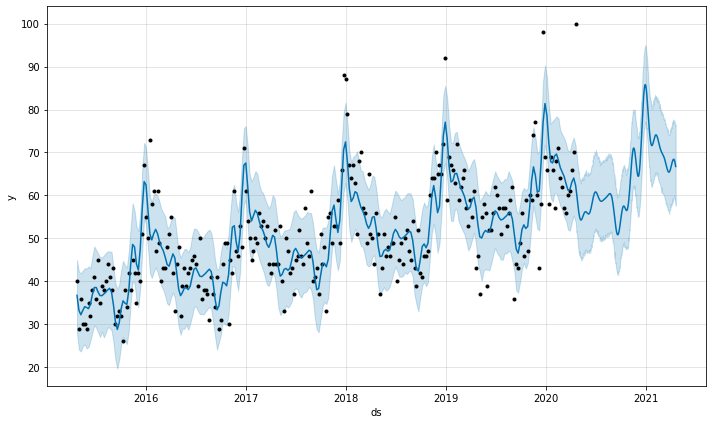

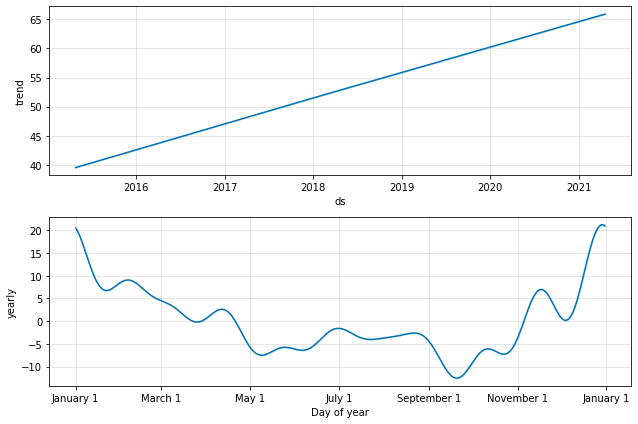

In [8]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [11]:
import altair as alt
from vega_datasets import data

states = alt.topo_feature(data.us_10m.url, 'states')
capitals = pd.read_json(data.us_state_capitals.url)
geo['state'] = geo['geoName']
geo_toilet = capitals.merge(geo, on='state')

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

geo_toilet['scaled'] = scaler.fit_transform(geo_toilet['unclog toilet'].values.reshape(-1,1)).round(1)
geo_toilet['img'] = 'https://vega.github.io/vega-datasets/data/7zip.png'
# US states background
background = alt.Chart(states).mark_geoshape(
    fill='#eee',
    stroke='darkgray',
).properties(
    title='US State Toilet Cloggage',
    width=650,
    height=400
).project('albersUsa')

# Points and text
hover = alt.selection(type='single', on='mouseover', nearest=True,
                      fields=['lat', 'lon'])

base = alt.Chart(geo_toilet).encode(
    longitude='lon:Q',
    latitude='lat:Q',
)

text = base.mark_text(dy=-5, size=25, align='right', color='purple').encode(
    alt.Text('scaled', type='ordinal'),
    opacity=alt.condition(~hover, alt.value(0), alt.value(1))
)

points = base.mark_circle().encode(
    size='scaled:Q',
    color='scaled',
    tooltip='state'
).add_selection(hover)

loo_map = background + points + text

In [16]:
from datapane import Report, Plot, Table, Markdown, Asset

report = [
    Markdown(f"""### Analysing clogged toilets with Google Trends
You may often find yourself wondering about the seasonality and geopraphy of toilet clogging. Which US states are the biggest culprits? Is it worse at a certain time of year?
Thanks to the marvels of modern data, we can pull this information from the Google Trends API and find out..."""),
    Table.create(df),
    Markdown("Let's plot this, both over time and per month (using the Python library Altair).."),
    Plot.create(all_trends),
    Markdown("Toilet clogging looks pretty seasonal, with a big spike around Christmas, which makes sense (I guess?) It seems to be generally growing over time, and we are at an all time high, presumably due to folks isolating and working from home.\n\nLet's use Facebook's Prophet forecasting library to try and forecast for the coming years, and analyse the nature of the seasonality."),
    Table.create(forecast),
    Plot.create(fig1),
    Plot.create(fig2),
    Markdown("Looks like 2021 is going to be a big year for clogged toilets."),
    Markdown("### The geography of cloggage\nWe can also query Google Trends to find which states are the biggest culprits, and plot it on an interactive map."),
    Plot.create(loo_map),
    Table.create(geo),
    Markdown("""### Conclusion\n
I hope you found these important analyses and visualisations informative. You can find the notebook which generated this report [on Github]().
If there's enough interest, I'd be happy to upload it to Datapane as an interactive script which works with other keywords.
""")
]

Report.create(*report).preview()

13:51:28 [INFO ] Uploading assets for Report


INFO:datapane:Uploading assets for Report


13:51:28 [INFO ] Uploading /var/folders/_x/188lgf3s507dygvl0b1l8rn40000gn/T/datapane-temp-lurrc1_6.df.json.gz


INFO:datapane:Uploading /var/folders/_x/188lgf3s507dygvl0b1l8rn40000gn/T/datapane-temp-lurrc1_6.df.json.gz


13:51:30 [INFO ] Uploading results_013.vl.json.gz


INFO:datapane:Uploading results_013.vl.json.gz


13:51:31 [INFO ] Uploading /var/folders/_x/188lgf3s507dygvl0b1l8rn40000gn/T/datapane-temp-ntzyblbl.df.json.gz


INFO:datapane:Uploading /var/folders/_x/188lgf3s507dygvl0b1l8rn40000gn/T/datapane-temp-ntzyblbl.df.json.gz


13:51:32 [INFO ] Uploading results_014.svg.gz


INFO:datapane:Uploading results_014.svg.gz


13:51:33 [INFO ] Uploading results_015.svg.gz


INFO:datapane:Uploading results_015.svg.gz


13:51:34 [INFO ] Uploading results_016.vl.json.gz


INFO:datapane:Uploading results_016.vl.json.gz


13:51:35 [INFO ] Uploading /var/folders/_x/188lgf3s507dygvl0b1l8rn40000gn/T/datapane-temp-o3a32fo2.df.json.gz


INFO:datapane:Uploading /var/folders/_x/188lgf3s507dygvl0b1l8rn40000gn/T/datapane-temp-o3a32fo2.df.json.gz
